# Bitcoin analysis based on historical data using Pyspark 

**Goals**:
1. Importing Bitcoin Historical dataset to Spark.
2. Understanding of the dataset
3. Visualizing the data 
3. Performing analysis by Linear Regression
4. Present/Visualize your results.


# Columns

**Timestamp** -> Date (in Epoch Unix format) of data collection; It will later be transformed into a "human" date for better understanding; Intervals of approximately 1 in 1 minute, with time zone set to UTC.

**Open** -> Initial currency trading value in that measurement range, in USD.

**High** -> Highest value reached by the asset during that measurement interval, in USD.

**Low** -> Lowest value reached by the asset during that measurement interval, in USD.

**Close** -> Value of the asset at the time of closing the measurement range, in USD.

**Volume_ (BTC)** -> Volume, in BTC, traded on Bitstamp during a given measurement interval

**Volume_ (Currency)** -> Volume, in USD, traded on Bitstamp during a given measurement interval;

**Weighted_Price** -> Average asset price in that range, in USD; Calculated based on traded volumes; It will be considered as the average price for analytical issues.

# Import required Libraries

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

In [2]:
import pyspark
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *

In [3]:
# setting random seed for notebook reproducability
rnd_seed=23
np.random.seed=rnd_seed
np.random.set_state=rnd_seed

# Creating the Spark Session

In [4]:
spark_session = SparkSession.builder\
        .master("spark://192.168.2.250:7077") \
        .appName("Lecture2_Spark_SQL")\
        .config("spark.dynamicAllocation.enabled", True)\
        .config("spark.dynamicAllocation.shuffleTracking.enabled",True)\
        .config("spark.shuffle.service.enabled", False)\
        .config("spark.dynamicAllocation.executorIdleTimeout","30s")\
        .config("spark.executor.cores", 6)\
        .config("spark.driver.port",9999)\
        .config("spark.blockManager.port",10005)\
        .getOrCreate()

sc = spark_session.sparkContext

sc.setLogLevel("ERROR")

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/01/29 14:19:06 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/01/29 14:19:06 WARN Utils: Service 'sparkDriver' could not bind on port 9999. Attempting port 10000.
24/01/29 14:19:07 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.
24/01/29 14:19:07 WARN Utils: Service 'org.apache.spark.network.netty.NettyBlockTransferService' could not bind on port 10005. Attempting port 10006.


In [5]:
spark_session

In [6]:
sqlContext = SQLContext(spark_session.sparkContext)
sqlContext

/home/ubuntu/.local/lib/python3.8/site-packages/pyspark/sql/context.py:113: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


# Performing Spark commands using Pyspark

In [8]:
#Loading Data to dataframe, store in cache memory to increase speed
df= sqlContext.read.csv('hdfs://192.168.2.250:9000/bitstampUSD_1-min_data_2012-01-01_to_2021-03-31.csv',
                        header='true', inferSchema='true').cache()

In [9]:
df.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325317980| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318100| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318160| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318220| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318280| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318340| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318400| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325318460| NaN| NaN| NaN|  NaN|       

In [10]:
#getting the schema info from the dataframe
df.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



# Data Exploration and Preprocessing

In [11]:
# Count total number of rows
df.count()

# Maximum rows in excel: 1,048,576
# https://support.office.com/en-us/article/excel-specifications-and-limits-1672b34d-7043-467e-8e27-269d656771c3

# Count the total number of columns
len(df.columns)

8

In [12]:
df.rdd.getNumPartitions()

6

In [13]:
# you can change the number of partitions by .repartition()
df1=df.repartition(10)
df1.rdd.getNumPartitions()

10

In [13]:
# To use ANSI SQL query similar to RDBMS, you need to create a temporary table
df.createOrReplaceTempView('bitstampUSD') #creating a temp view table
bitstampUSD = sqlContext.sql("select *,from_unixtime(Timestamp) as `dateTime` from bitstampUSD")
bitstampUSD=bitstampUSD.dropna('any') # Removing NA values
bitstampUSD.show()
# Count total number of rows after removing the NA values
bitstampUSD.count()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 15:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 16:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 17:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 04:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 15:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 22:45:00|


3613769

In [14]:
from datetime import datetime
ts = int('1325317920')
print(datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S'))

2011-12-31 07:52:00


In [15]:
# You can also use udf to do the same thing

from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from datetime import datetime


def unix_timestamp(ts):
    try:
        dt = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    except ValueError:
        # if you encounter a "year is out of range" error the timestamp
        # may be in milliseconds, try `ts /= 1000` in that case
        ts /= 1000
        dt = datetime.utcfromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
    return dt

# User-defined function. return type is a string.
udf_unix_ts = udf(unix_timestamp, StringType())


df_stamp = df.withColumn("dateTime", udf_unix_ts("Timestamp")).dropna('any')

df_stamp.show()

df_stamp.count()

df_stamp.select('Weighted_Price').summary().show()

# Looks a lot like a Pandas!

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 15:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 16:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 17:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 04:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 15:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 22:45:00|


+-------+-----------------+
|summary|   Weighted_Price|
+-------+-----------------+
|  count|          3613769|
|   mean|6008.934800288688|
| stddev|8995.991643412915|
|    min|              3.8|
|    25%|     443.78638366|
|    50%|     3596.7265557|
|    75%|     8627.2553524|
|    max|     61716.205341|
+-------+-----------------+



In [16]:
#Renaming the columns 
bitstampUSD=bitstampUSD.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [17]:
#Creating another dataframe to perform Datetime Visualization 
DateTime_df= bitstampUSD
#DateTime_df.show()

In [18]:
#Splitting dateTime to date and time
splitDF = DateTime_df.withColumn("date",split(col("dateTime")," ").getItem(0))
splitDF = splitDF.withColumn("time",split(col("dateTime")," ").getItem(1))
splitDF.printSchema()
splitDF.show()

#Splitting hours from time
splitDFHour = splitDF.withColumn("hour",split(col("time"),":").getItem(0))
#splitDFHour.printSchema()
#splitDFHour.show()

#Arranging Dataframe with column date and time and day_of_week
splitDFHour= splitDFHour.withColumn("date",splitDFHour["date"].cast(DateType())).withColumn("hour",splitDFHour["hour"].cast(DoubleType())).withColumn("dateTime",splitDFHour["dateTime"].cast(DateType()))
splitDFHour=splitDFHour.withColumn('day_of_week',dayofweek(splitDFHour.date))
#splitDFHour.printSchema()
#splitDFHour.show()

#Arranging Dataframe with column date and time and year
splitDFWithYear = splitDFHour.withColumn("year",split(col("date"),"-").getItem(0))
splitDFWithYear.show()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 07:52:00|2011-12-31|07:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 15:50:00|2011-12-31|15:50:00|

In [19]:
# you can also do this using the built-in function in pyspark.sql
# explore more on pyspark.sql.functions APIs
splitDF.withColumn("hour",pyspark.sql.functions.hour("time"))\
       .withColumn("day_of_week",pyspark.sql.functions.dayofweek("date"))\
       .withColumn("year",pyspark.sql.functions.year("date"))\
       .show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 07:52:00|2011-12-31|07:52:00|   7|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 15:50:00|2011-12-31|15:50:00|  15|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 16:59:00|2011-12-31|16:59:00|  16|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 17:00:00|2011-12-31|17:00:00|  17|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|   

In [20]:
# Spark to Pandas dataframe
pandas_converted=splitDFWithYear.toPandas()

In [21]:
# Getting the values in list so that we can plot and visualize it
hour=pandas_converted["hour"].values.tolist()
weighted_price=pandas_converted["Weighted_Price"].values.tolist()
volume_BTC=pandas_converted["VolBTC"].values.tolist()
date_of_week=pandas_converted["day_of_week"].values.tolist()
year=pandas_converted["year"].values.tolist()

In [22]:
# you can save table as csv file for later use 
#splitDFWitYear.write.format('csv').save('hdfs://192.168.2.70:9000/bitcoin_with_splitted_date.csv')

# Data Visualization

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt
#visualization
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)

from matplotlib import rcParams
sns.set(context='notebook', style='whitegrid', rc={'figure.figsize': (18,4)})
rcParams['figure.figsize'] = 18,4

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

/tmp/ipykernel_57573/2481867968.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr=pandas_converted.corr()


<AxesSubplot: >

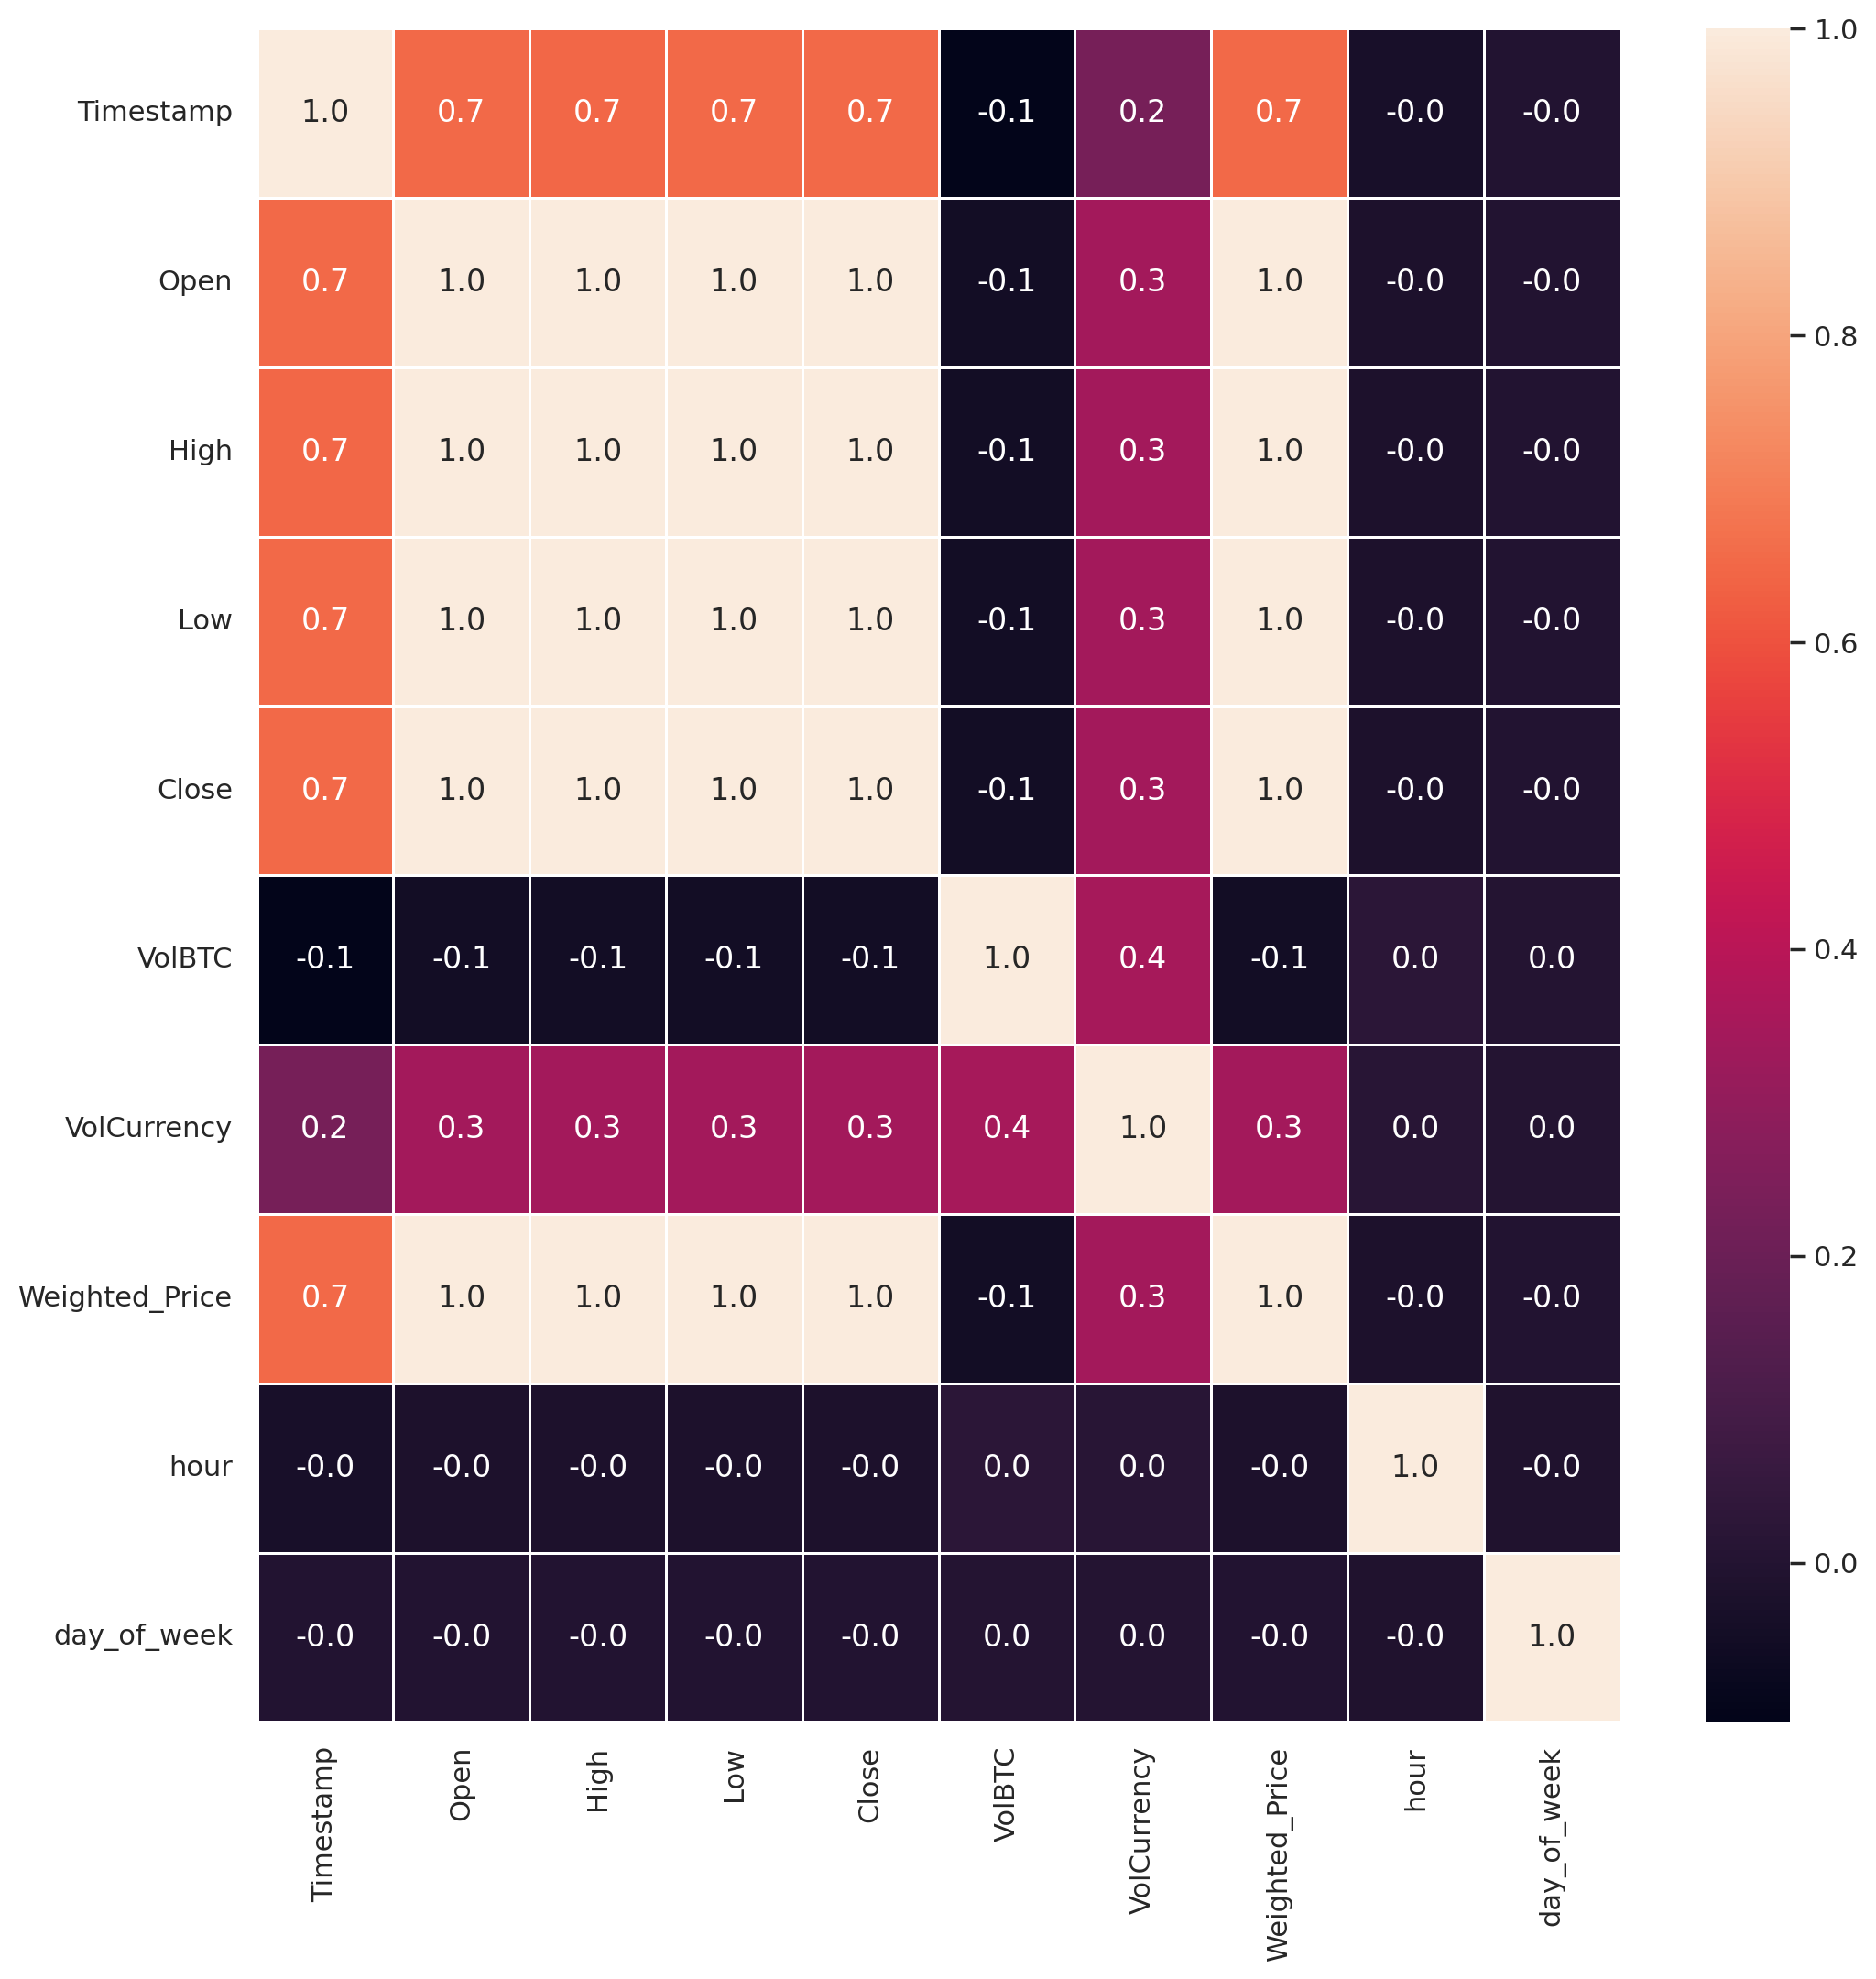

In [24]:
#Correlation plotting the heatmap using Seaborn
corr=pandas_converted.corr()
f,ax = plt.subplots(figsize=(12, 12))
sns.heatmap(corr,annot=True,linewidths=.5, fmt= '.1f',ax=ax)

<AxesSubplot: xlabel='VolBTC', ylabel='VolCurrency'>

Text(0.5, 0, 'BTC Volume')

Text(0, 0.5, 'Currency Volume')

Text(0.5, 1.0, 'BTC-Currency Scatter Plot')

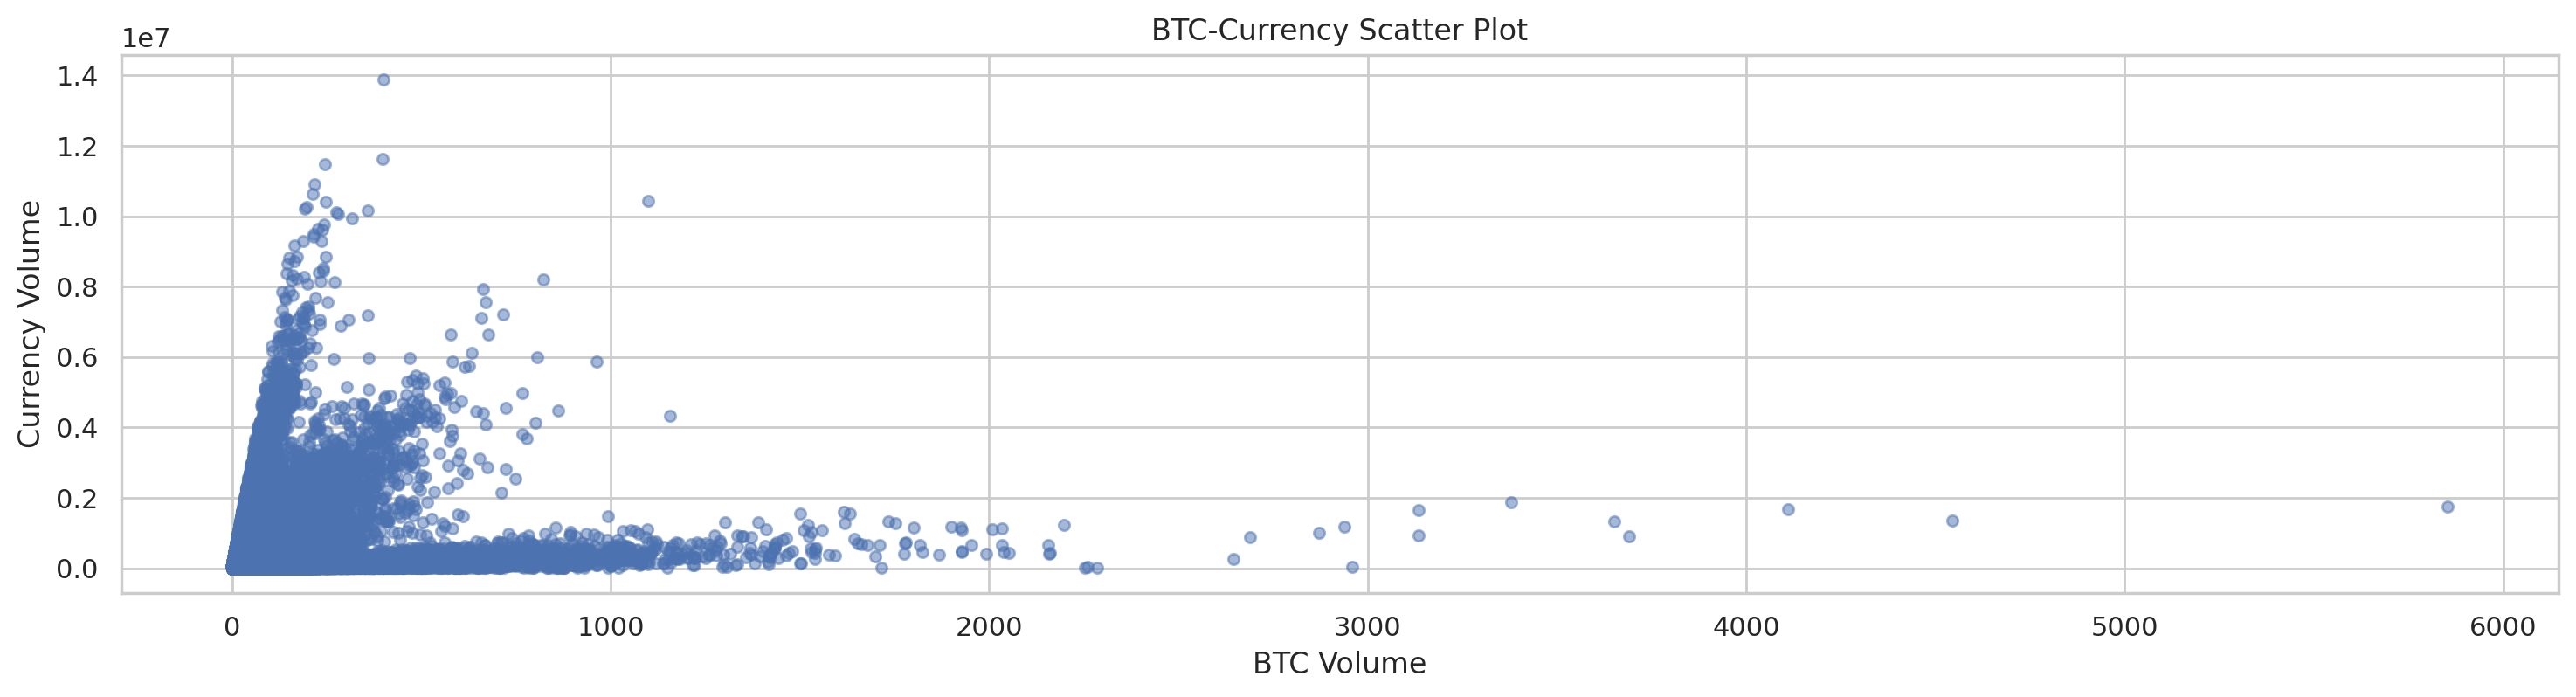

In [25]:
# Scatter Plot usage by Matplotlib
# x = open, y = close
pandas_converted.plot(kind='scatter', x='VolBTC', y='VolCurrency',alpha = 0.5)
plt.xlabel('BTC Volume')            
plt.ylabel('Currency Volume')
plt.title('BTC-Currency Scatter Plot') 
plt.show()

<Figure size 1600x400 with 0 Axes>

<AxesSubplot: >

<AxesSubplot: >

Text(0.5, 0, 'Time')

Text(0, 0.5, 'price at the start of the time window')

Text(0.5, 1.0, 'Line plot')

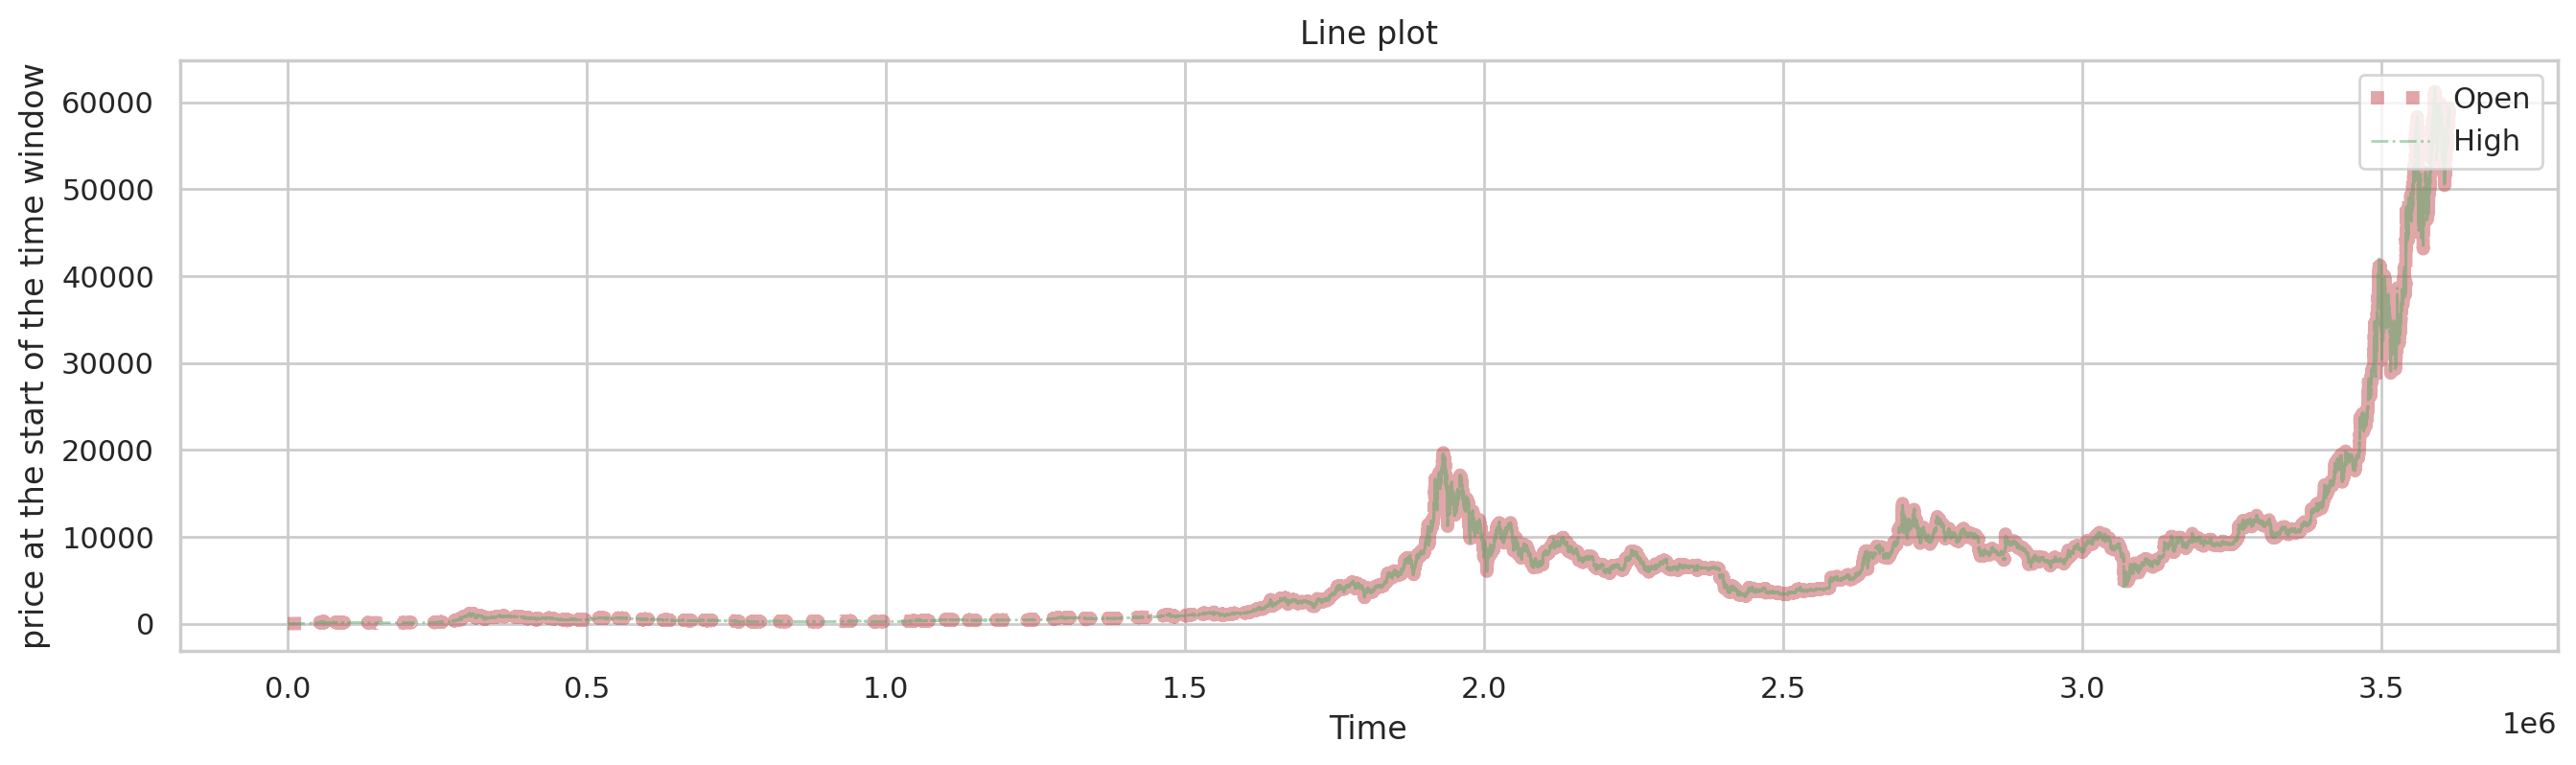

In [26]:
# Line Plot usage by Matplotlib plotting Open with High with Time on X axis
# color = color, label = label, linewidth = width of line, alpha = opacity, grid = gray square background, linestyle = sytle of line

plt.figure(figsize=(16,4))
pandas_converted.Open.plot(kind='line', color='r', label='Open', alpha=0.5, linewidth=5, grid=True, linestyle=':')
pandas_converted.High.plot(color='g', label='High', linewidth=1, alpha=0.5, grid=True, linestyle='-.')
plt.legend(loc='upper right') #legend put label into plot
plt.xlabel('Time')
plt.ylabel('price at the start of the time window')
plt.title('Line plot')
plt.show()

<AxesSubplot: ylabel='Frequency'>

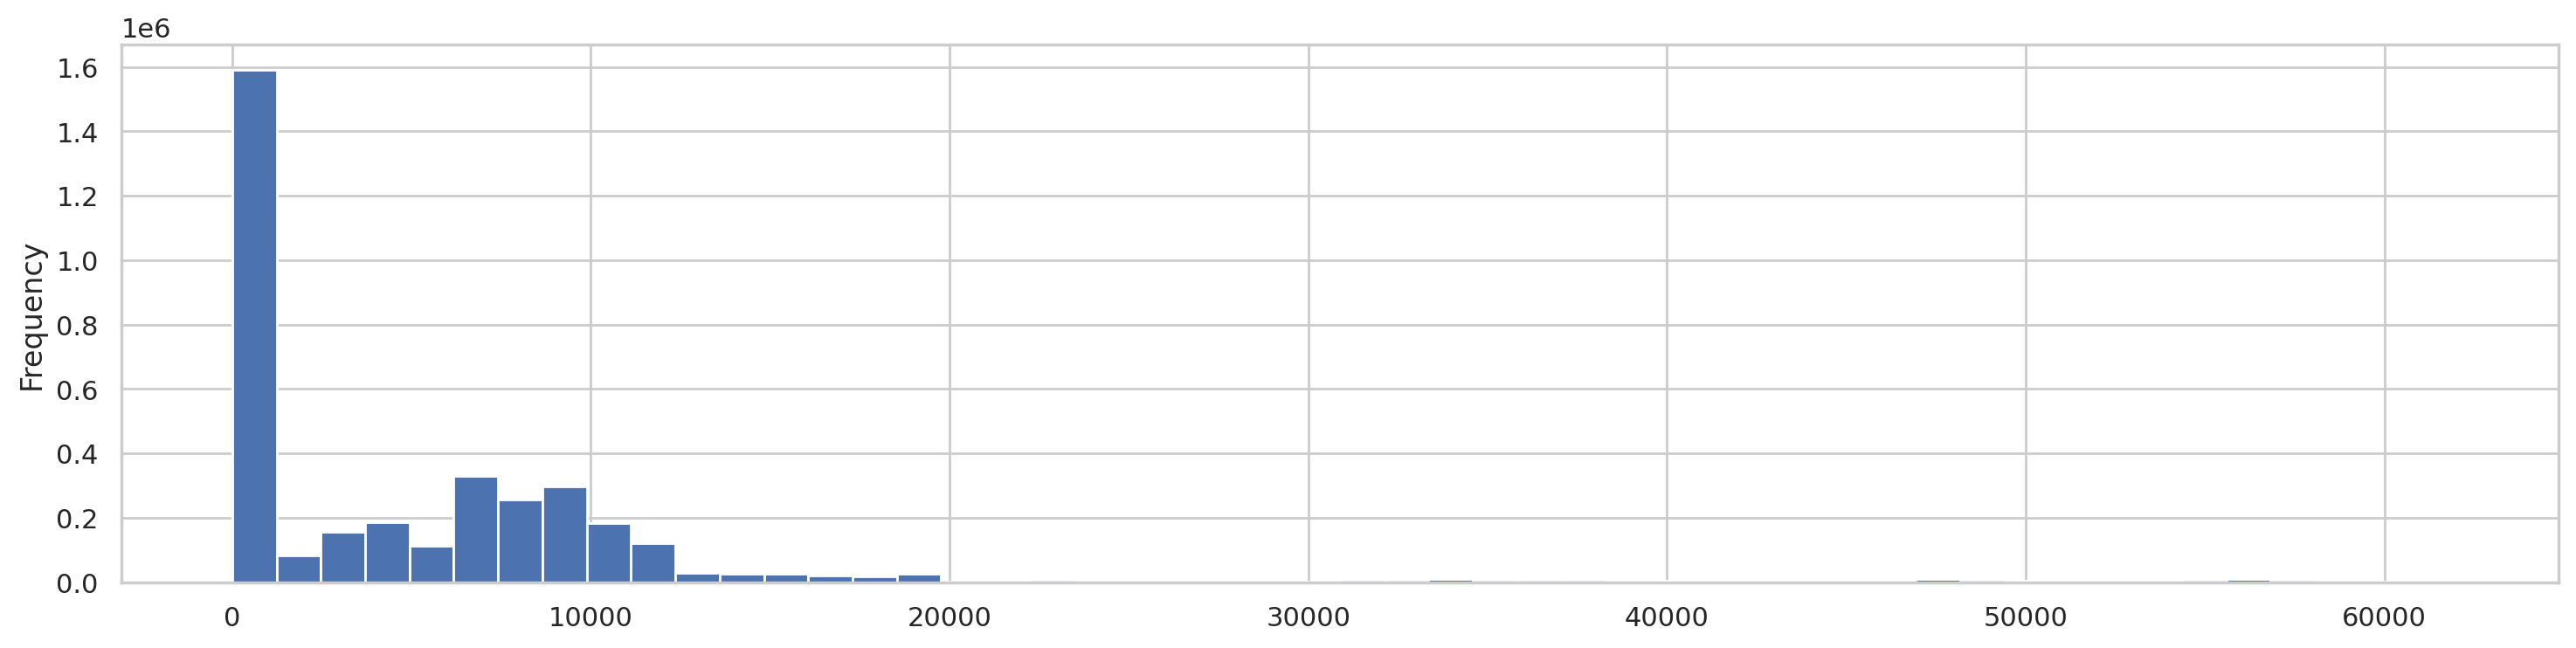

In [27]:
#Histogram plot of Open price
pandas_converted.Open.plot(kind='hist', bins=50)

Text(0.5, 0, 'hour')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price by Hour')

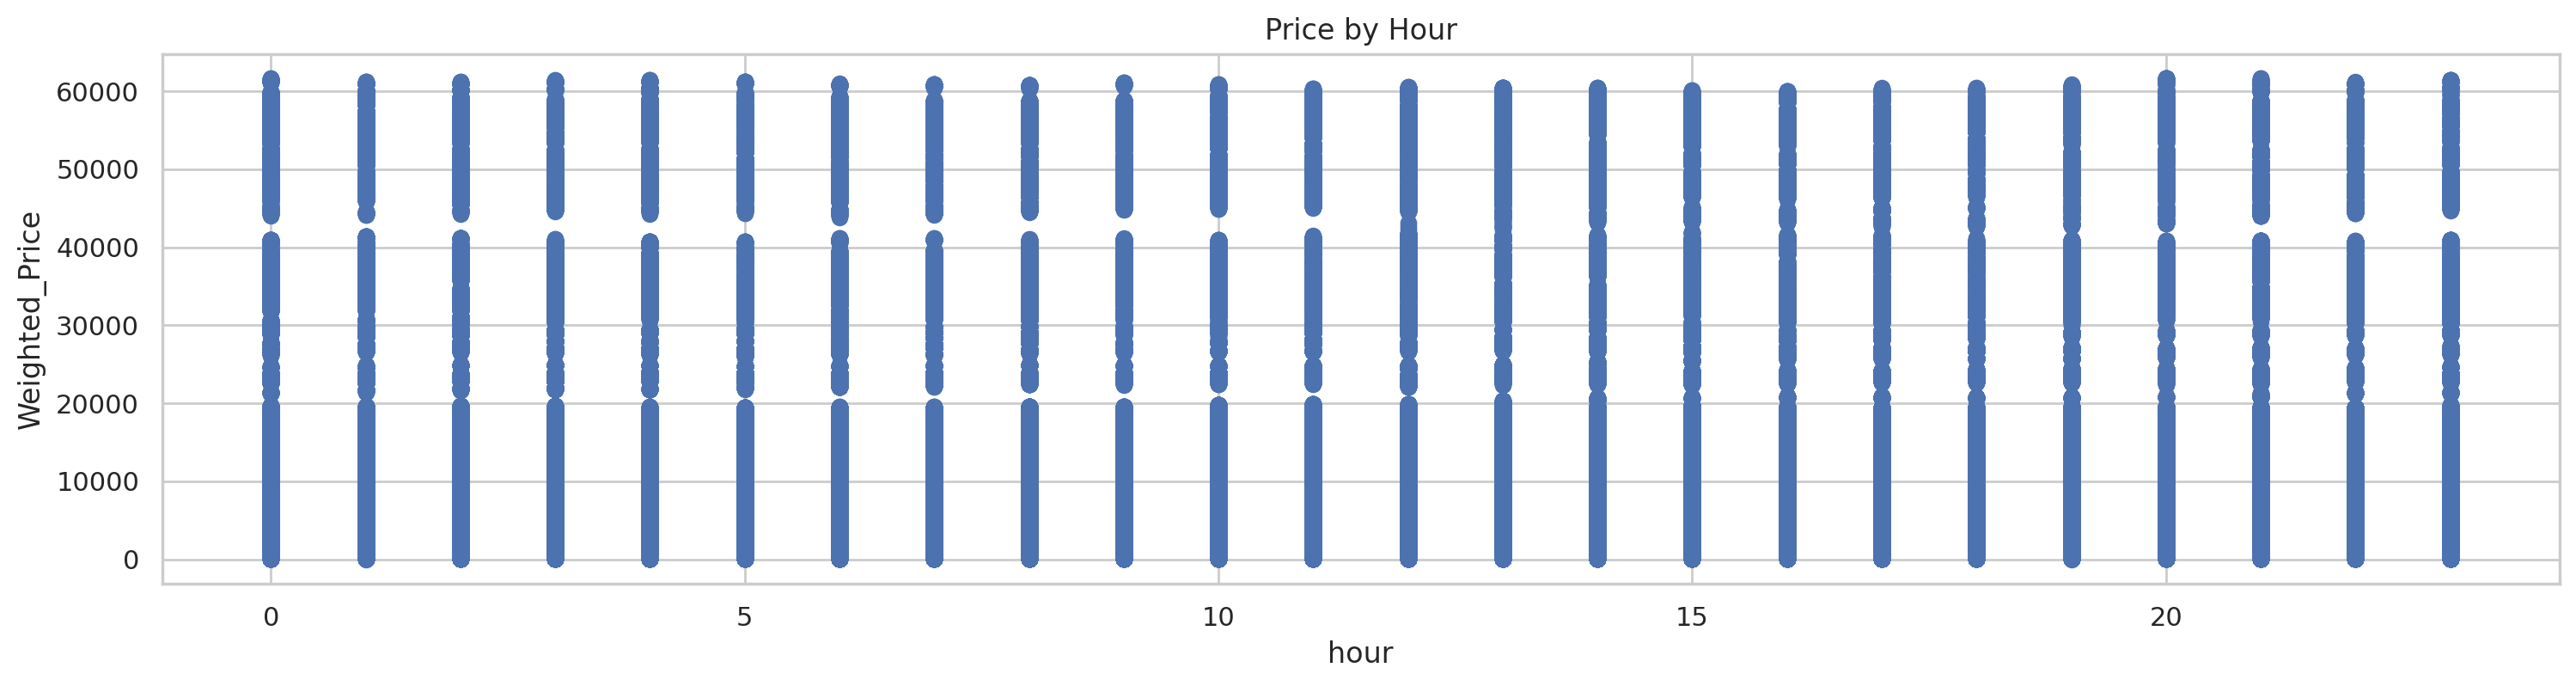

In [28]:
#Plot of Weighted_price per hour in scatter plot using Matplotlib
plt.plot(hour,weighted_price , 'bo')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('hour')            
plt.ylabel('Weighted_Price')
plt.title('Price by Hour') 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Price By Week')

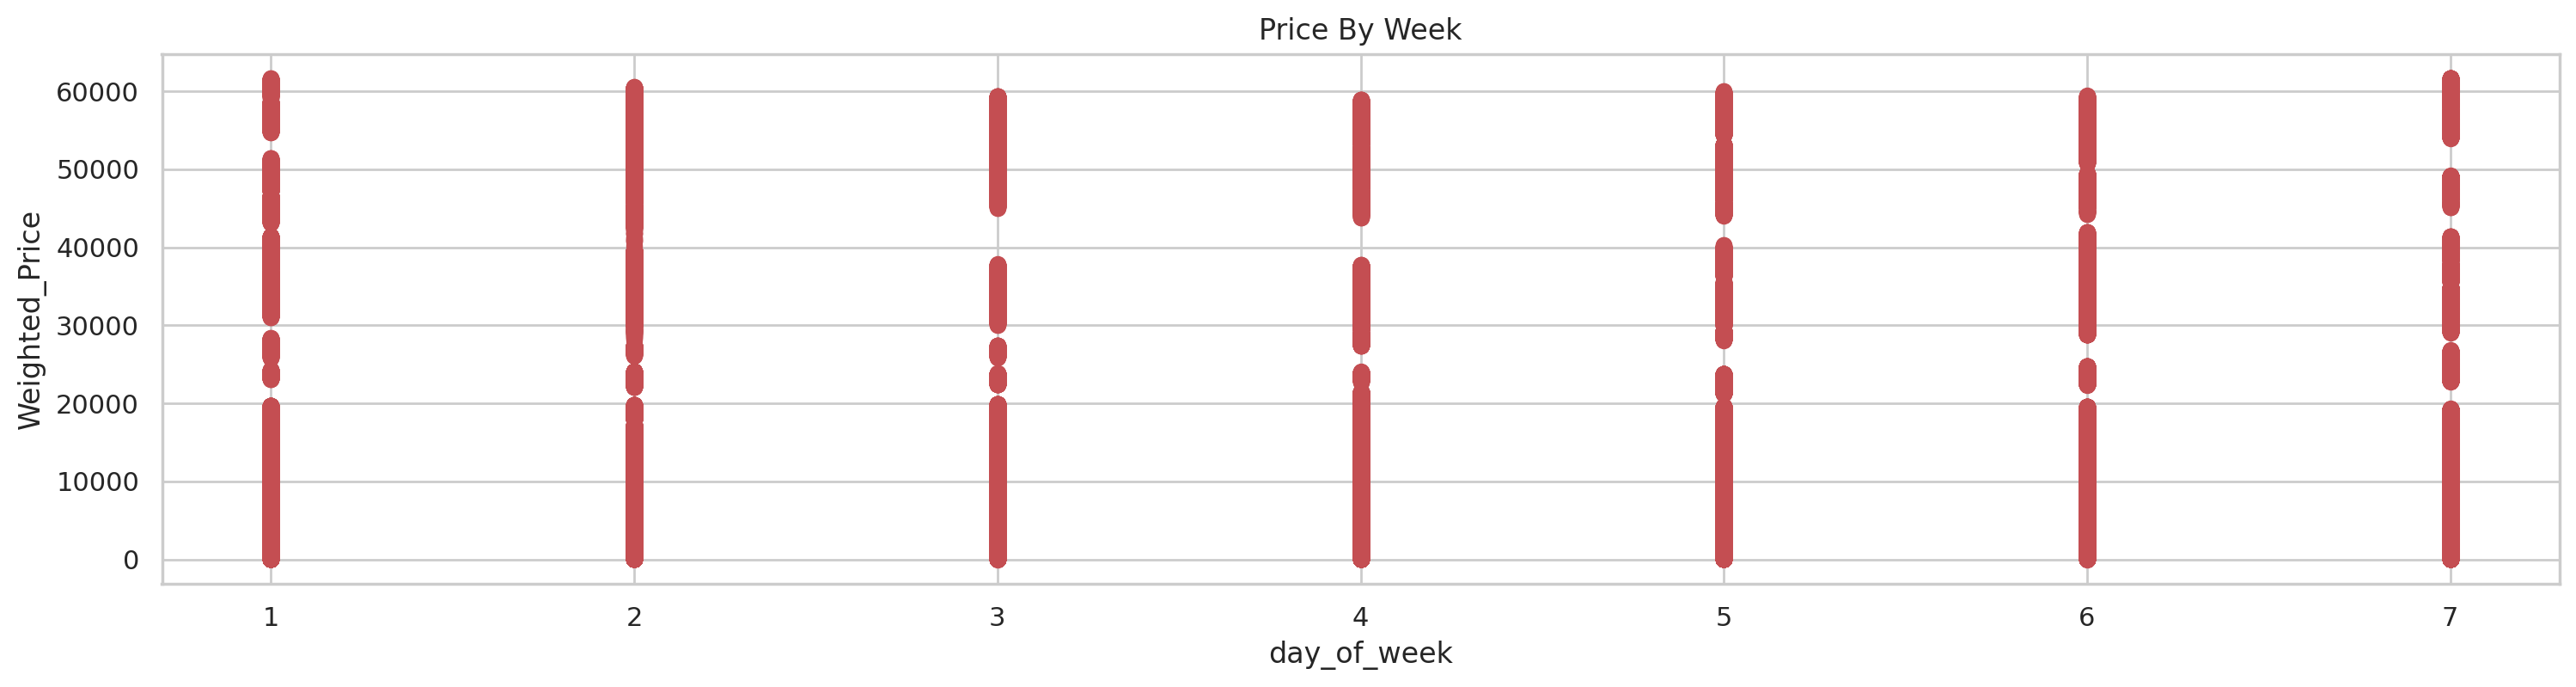

In [29]:
#Plot of Weighted_price per week in scatter plot using Matplotlib
plt.plot(date_of_week, weighted_price, 'ro')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('day_of_week')            
plt.ylabel('Weighted_Price')
plt.title('Price By Week') 
plt.show()

Text(0.5, 0, 'hour')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume by Hour of day')

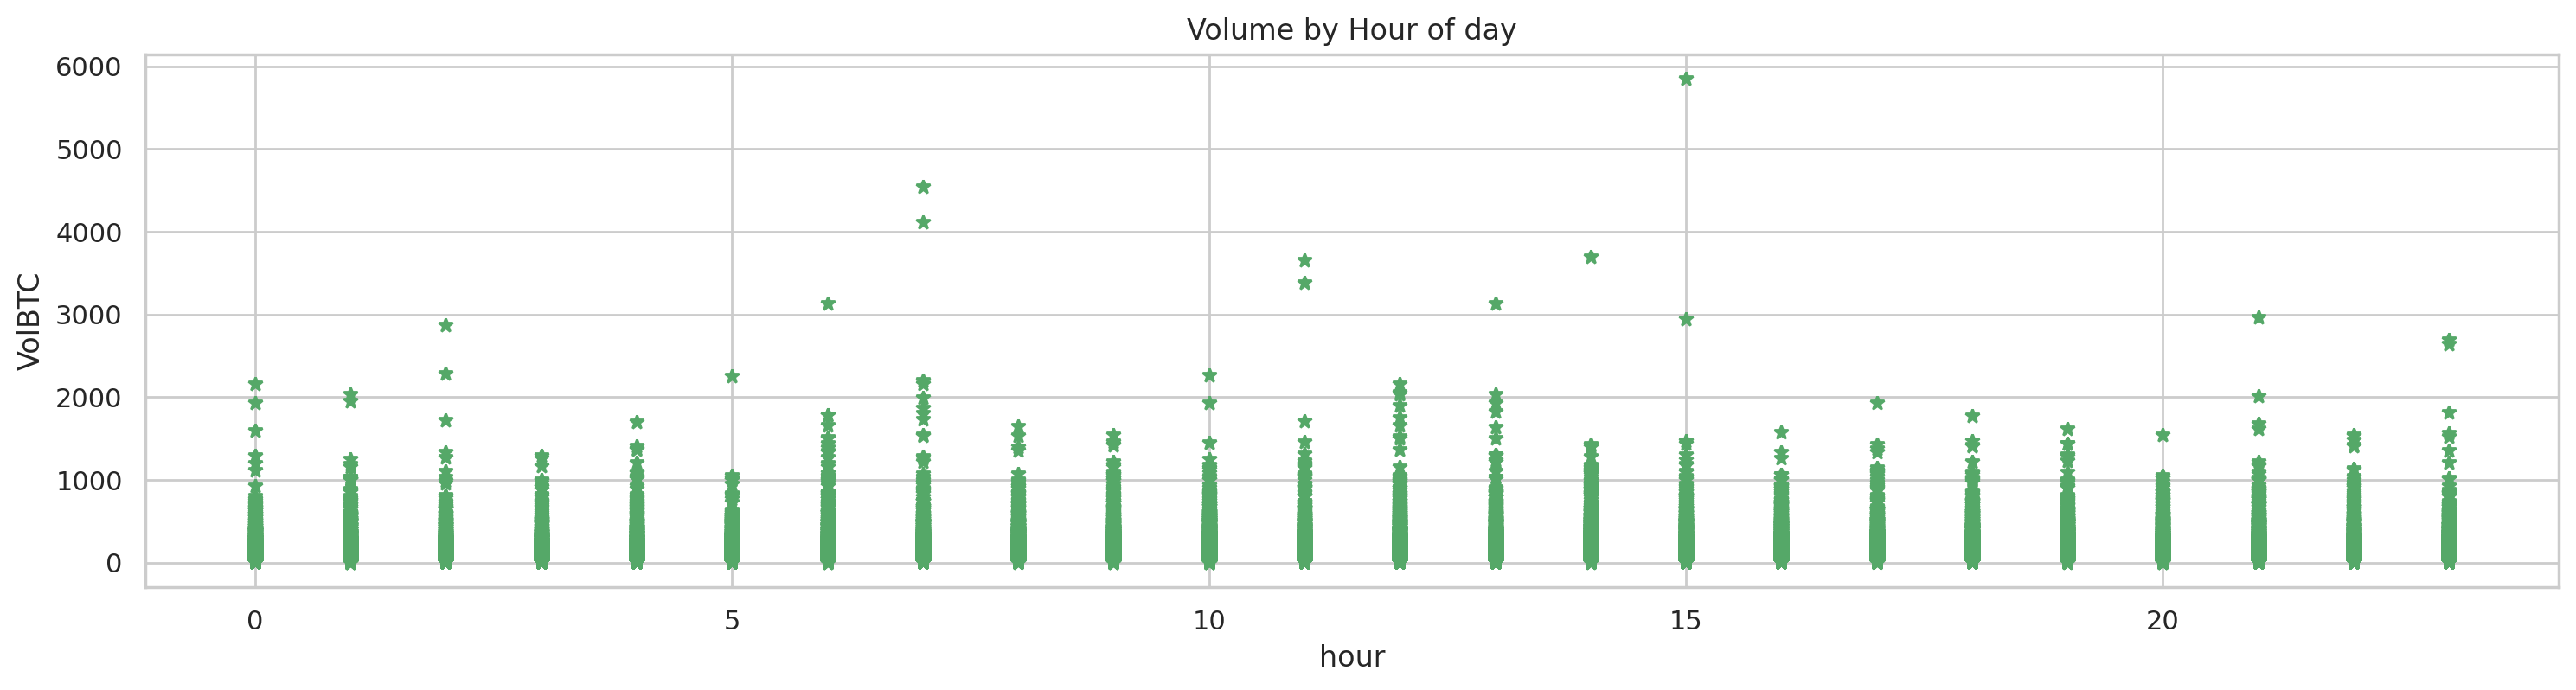

In [30]:
#Plot of VolBTC per hour change displayed in scatter plot using Matplotlib
plt.plot(hour, volume_BTC, 'g*')
#group1_pd.plot(kind='scatter', x='hour', y='Weighted_Price',alpha = 0.01)
plt.xlabel('hour')            
plt.ylabel('VolBTC')
plt.title('Volume by Hour of day') 
plt.show()

Text(0.5, 0, 'day_of_week')

Text(0, 0.5, 'VolBTC')

Text(0.5, 1.0, 'Volume By Week')

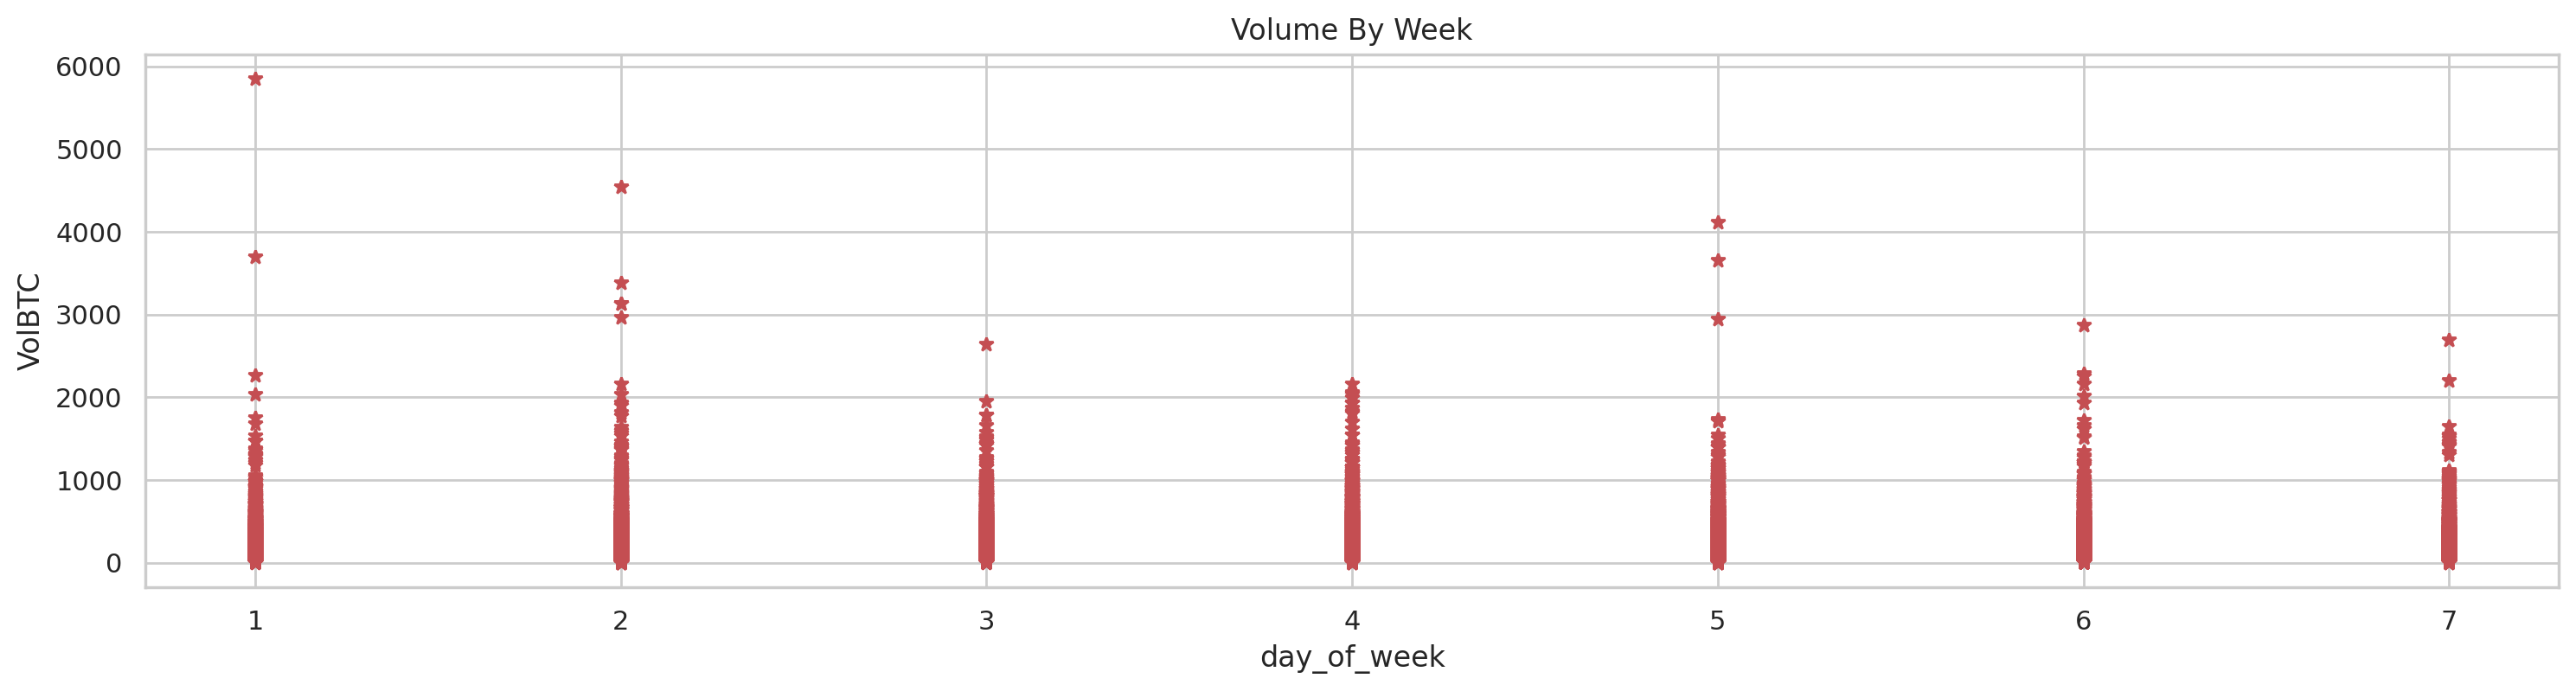

In [31]:
#Plot of VolBTC per day_of_Week change displayed in scatter plot using Matplotlib
plt.plot(date_of_week,volume_BTC , 'r*')
plt.xlabel('day_of_week')            
plt.ylabel('VolBTC')
plt.title('Volume By Week') 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'Weighted_Price')

Text(0.5, 1.0, 'Weighted Price plotted yearly basis')

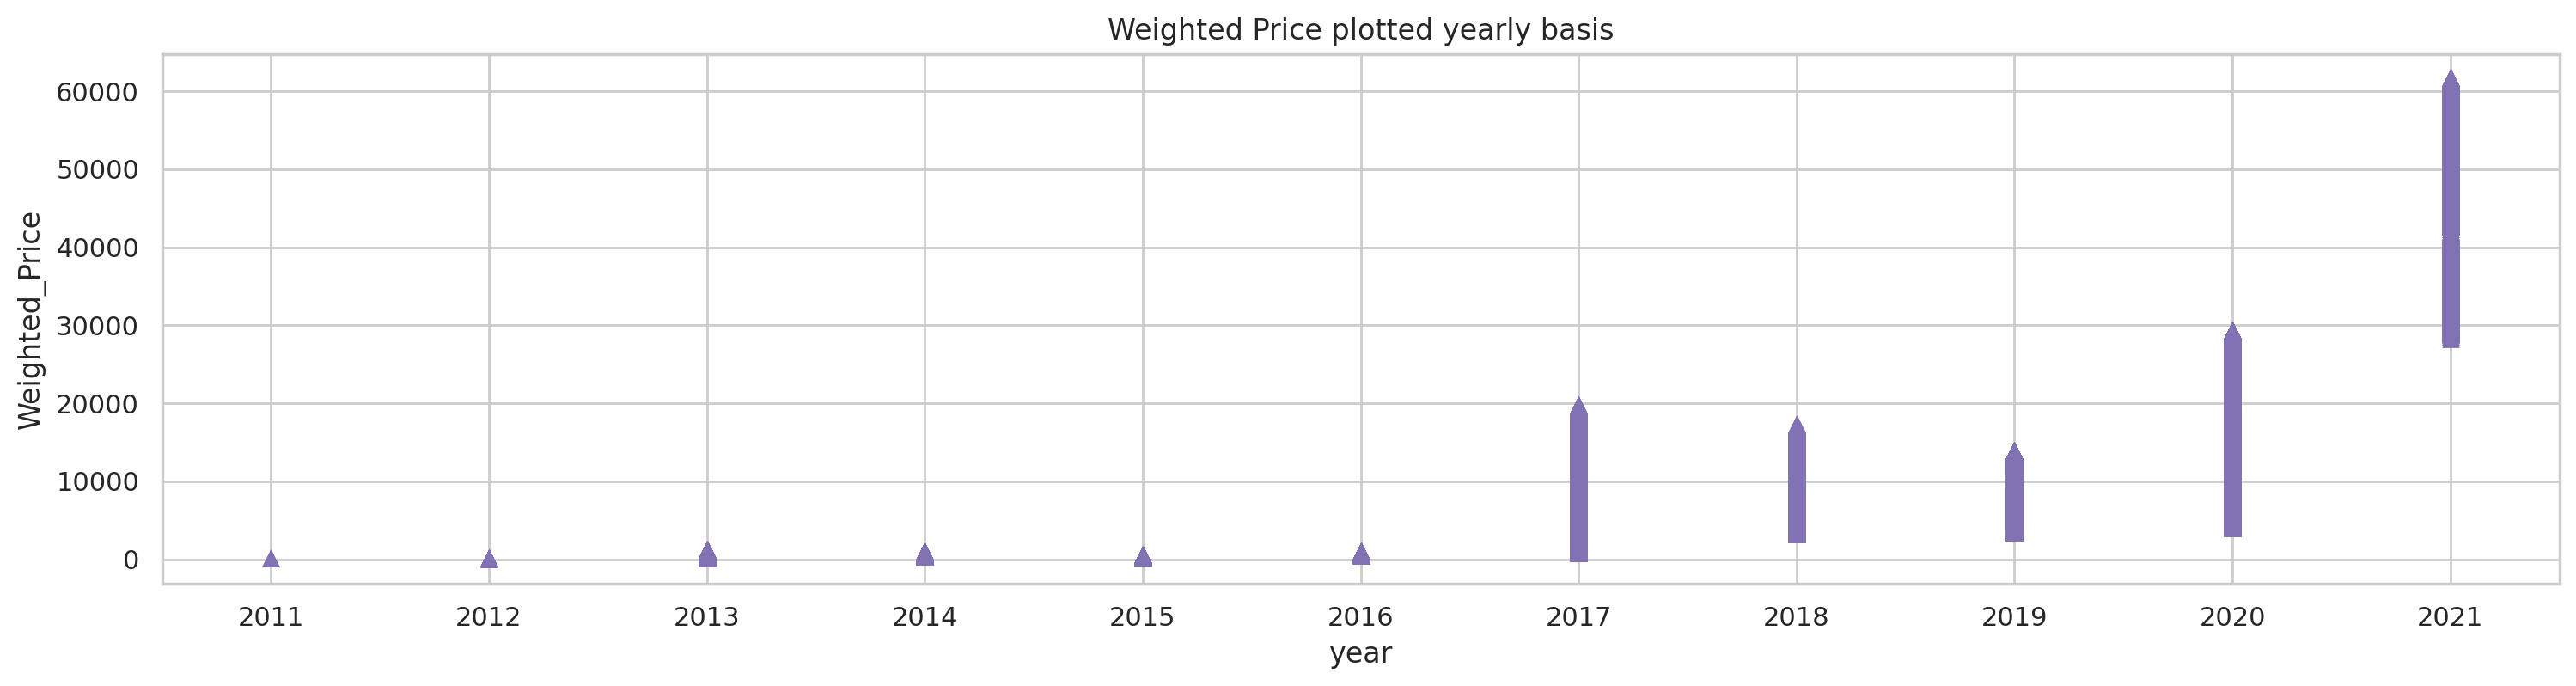

In [32]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,weighted_price , 'm^')
plt.xlabel('year')            
plt.ylabel('Weighted_Price')
plt.title('Weighted Price plotted yearly basis') 
plt.show()

Text(0.5, 0, 'year')

Text(0, 0.5, 'volume_BTC')

Text(0.5, 1.0, 'volume_BTC plotted yearly basis')

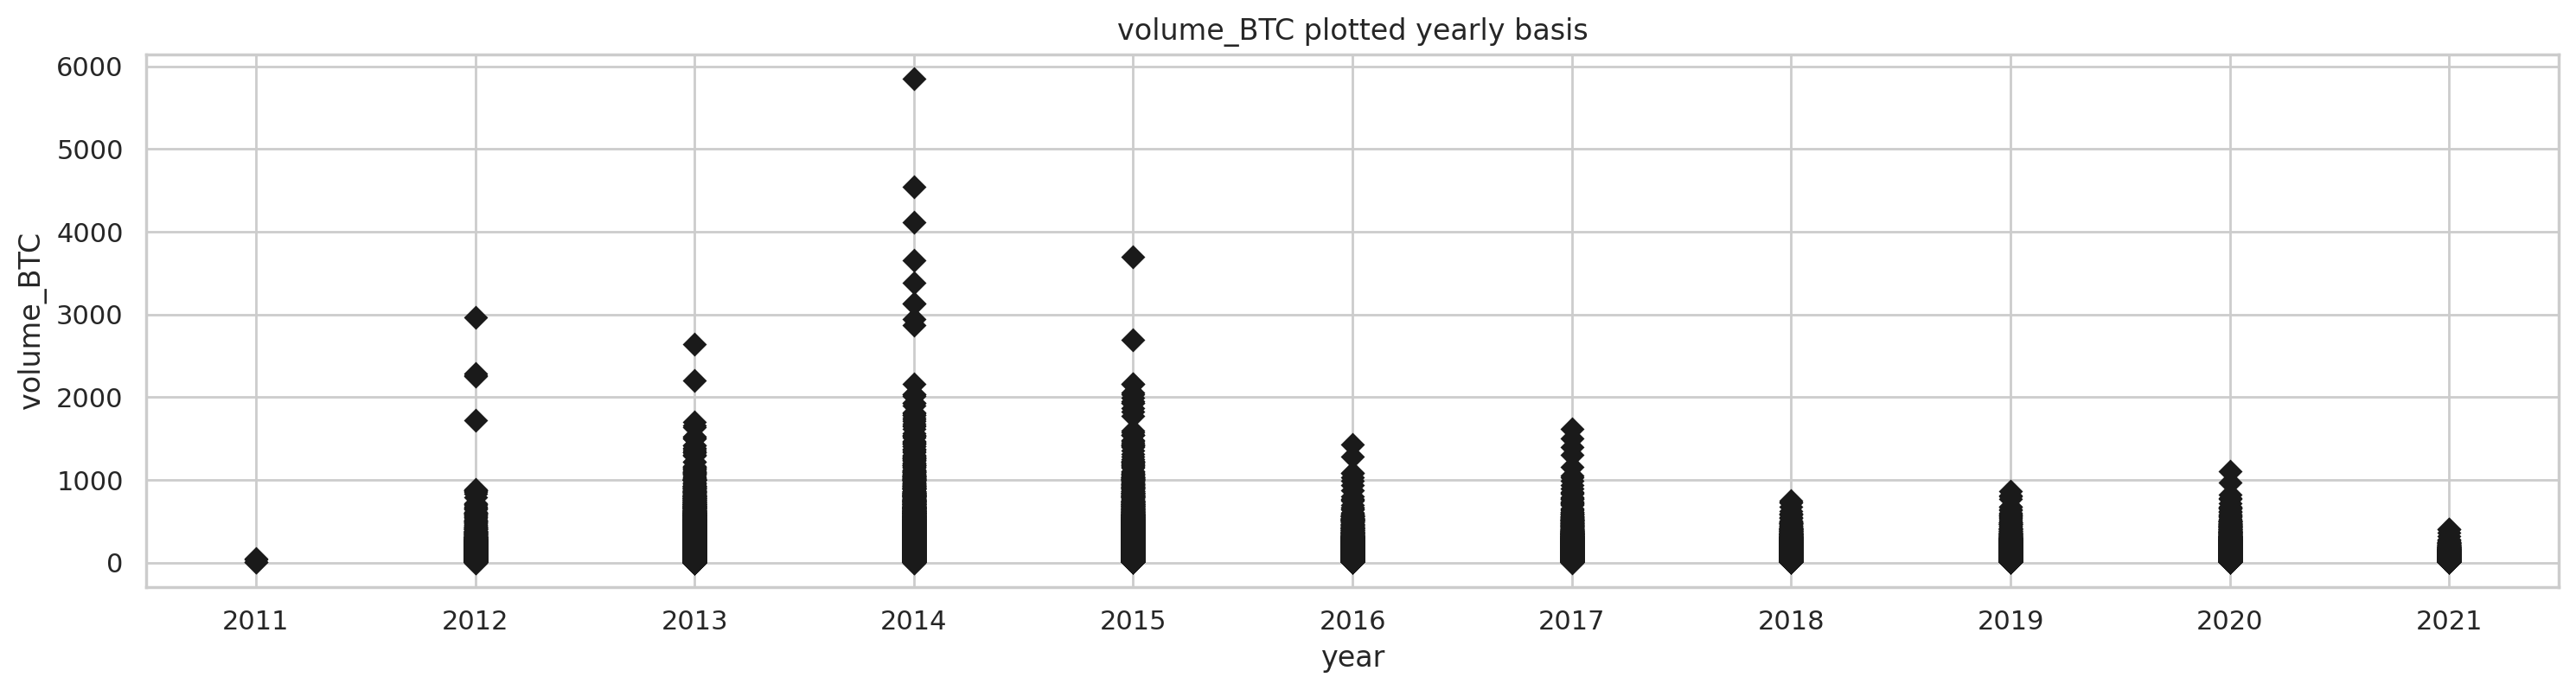

In [33]:
#Plot of Price per year change displayed in scatter plot using Matplotlib
plt.plot(year,volume_BTC , 'kD')
plt.xlabel('year')            
plt.ylabel('volume_BTC')
plt.title('volume_BTC plotted yearly basis') 
plt.show()

# Feature Engineering/Extraction
**Use a VectorAssembler to put features into a feature vector column**

We have generated enough information post preprocessing our data to feed it to the model.
All missing values, zero values have been excluded from the data set.
Next we will normalize our data (as minimize the ranges between Min and max values).

In [34]:
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [35]:
# put features into a feature vector column
assembler = VectorAssembler(inputCols=['Open','High', 'VolBTC', 'VolCurrency','Weighted_Price'], outputCol="features")
assembled_df = assembler.transform(bitstampUSD)
assembled_df.show(10, truncate= False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                                        |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 07:52:00|[4.39,4.39,0.45558087,2.0000000193,4.39]        |
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 15:50:00|[4.39,4.39,48.0,210.72,4.39]                    |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 16:59:00|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 17:00:00|[4.58,4.58,9.0,41.22,4.58]                      |

The result displays that the features have transformed into a Dense Vector.

# Normalization

Now we can scale the data using Min_Max_Scaler. The input columns are the features, and the output column with the rescaled that will be included in the scaled_df will be named "scaled_features".

In [36]:
# Initialize the `Min_Max_scaler`
Min_Max_scaler = MinMaxScaler(inputCol="features", outputCol="scaled_features")
# Fit the DataFrame to the scaler
scaled_df= Min_Max_scaler.fit(assembled_df).transform(assembled_df)
# Inspect the result
scaled_df.select("features", "scaled_features").show(10, truncate=False)
scaled_df.columns

+------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|features                                        |scaled_features                                                                                                |
+------------------------------------------------+---------------------------------------------------------------------------------------------------------------+
|[4.39,4.39,0.45558087,2.0000000193,4.39]        |[9.553145931914242E-6,9.550320720812882E-6,7.782582427582654E-5,1.4387793343672024E-7,9.560476483453811E-6]    |
|[4.39,4.39,48.0,210.72,4.39]                    |[9.553145931914242E-6,9.550320720812882E-6,0.008199728766573702,1.51589789206087E-5,9.560476483453811E-6]      |
|[4.5,4.57,37.86229723,171.38033753,4.5264114983]|[1.1334240936169445E-5,1.2463977889874449E-5,0.006467928495112392,1.2328924278777876E-5,1.1770915333572205E-5] |
|[4.58,4.58,9.0,41.22,

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

# Building A Machine Learning Model With Spark ML

As we have finished the preprocessing of our data, now we build our Linear Regression model. We first need to split the data into train and test sets, using the randomSplit() method:

In [37]:
# Split the data into train,test and Validation sets
train_data, test_data = scaled_df.randomSplit([.7,.3], seed=rnd_seed)

**Now we create an ElacticNet Linear Regression Model**

ElasticNet is a linear regression model trained with both l1 and l2 -norm regularization of the coefficients. This combination allows for learning a sparse model where few of the weights are non-zero like Lasso, while still maintaining the regularization properties of Ridge. We control the convex combination of l1 and l2 using the l1_ratio parameter.
Elastic-net is useful when there are multiple features which are correlated with one another. Lasso is likely to pick one of these at random, while elastic-net is likely to pick both.
Source: https://scikit-learn.org/stable/modules/linear_model.html#elastic-net

In [38]:
# Initialize `lr`
lr = (LinearRegression(featuresCol='scaled_features' , labelCol="Weighted_Price", predictionCol='Predicted_price', 
                               maxIter=100, regParam=0.3, elasticNetParam=0.8, standardization=False))

In [39]:
# Fit the data to the model
linearModel = lr.fit(train_data)

**Generate Predictions**

In [40]:
# Generate predictions
predictions = linearModel.transform(test_data)
# Select the columns and store in a variable
pred_data= predictions.select("Predicted_price", "Weighted_Price").show(20)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
| 6.34208802583872|          4.39|
|6.531978731436785|          4.58|
|6.951737133285141|           5.0|
|7.271553058502937|          5.32|
|7.241570315513767|          5.29|
|7.241570315513767|          5.29|
|7.141627838883207|          5.19|
| 7.31501315693787|  5.3604618117|
|7.723630170636842|   5.777027027|
|7.951161899590749|           6.0|
|7.951161899590749|           6.0|
|8.390908796765217|          6.44|
|8.370920301439105|          6.42|
| 8.38091454910216|          6.43|
|8.600787997689395|          6.65|
|8.600787997689395|          6.65|
|8.600787997689395|          6.65|
|8.450874282743554|           6.5|
|8.350931806112992|           6.4|
|8.250989329482431|           6.3|
+-----------------+--------------+
only showing top 20 rows



**Inspect the Metrics**

Now we look at some metrics to get a better idea of how good the model is performing actually. We will use Regression Evaluator and LinearRegressionModel.summary attribute to pull up the rootMeanSquaredError.
The rMSE measures how much error there is between two datasets comparing a predicted value and an observed or known value. The smaller an rMSE value, the closer predicted and observed values are.

In [41]:
# Select (predicted_price, Weighted_price label) and compute test error
evaluator = RegressionEvaluator(
    labelCol="Weighted_Price", predictionCol="Predicted_price", metricName="rmse")
rmse = evaluator.evaluate(predictions)
print("Root Mean Squared Error (RMSE) on test data = %g" % rmse)

Root Mean Squared Error (RMSE) on test data = 5.80429


Text(0.5, 1.0, 'Log Training Error vs. Iterations')

Text(0, 0.5, 'Log Training Error')

Text(0.5, 0, 'Iterations')

MAE: 2.9631094363365142


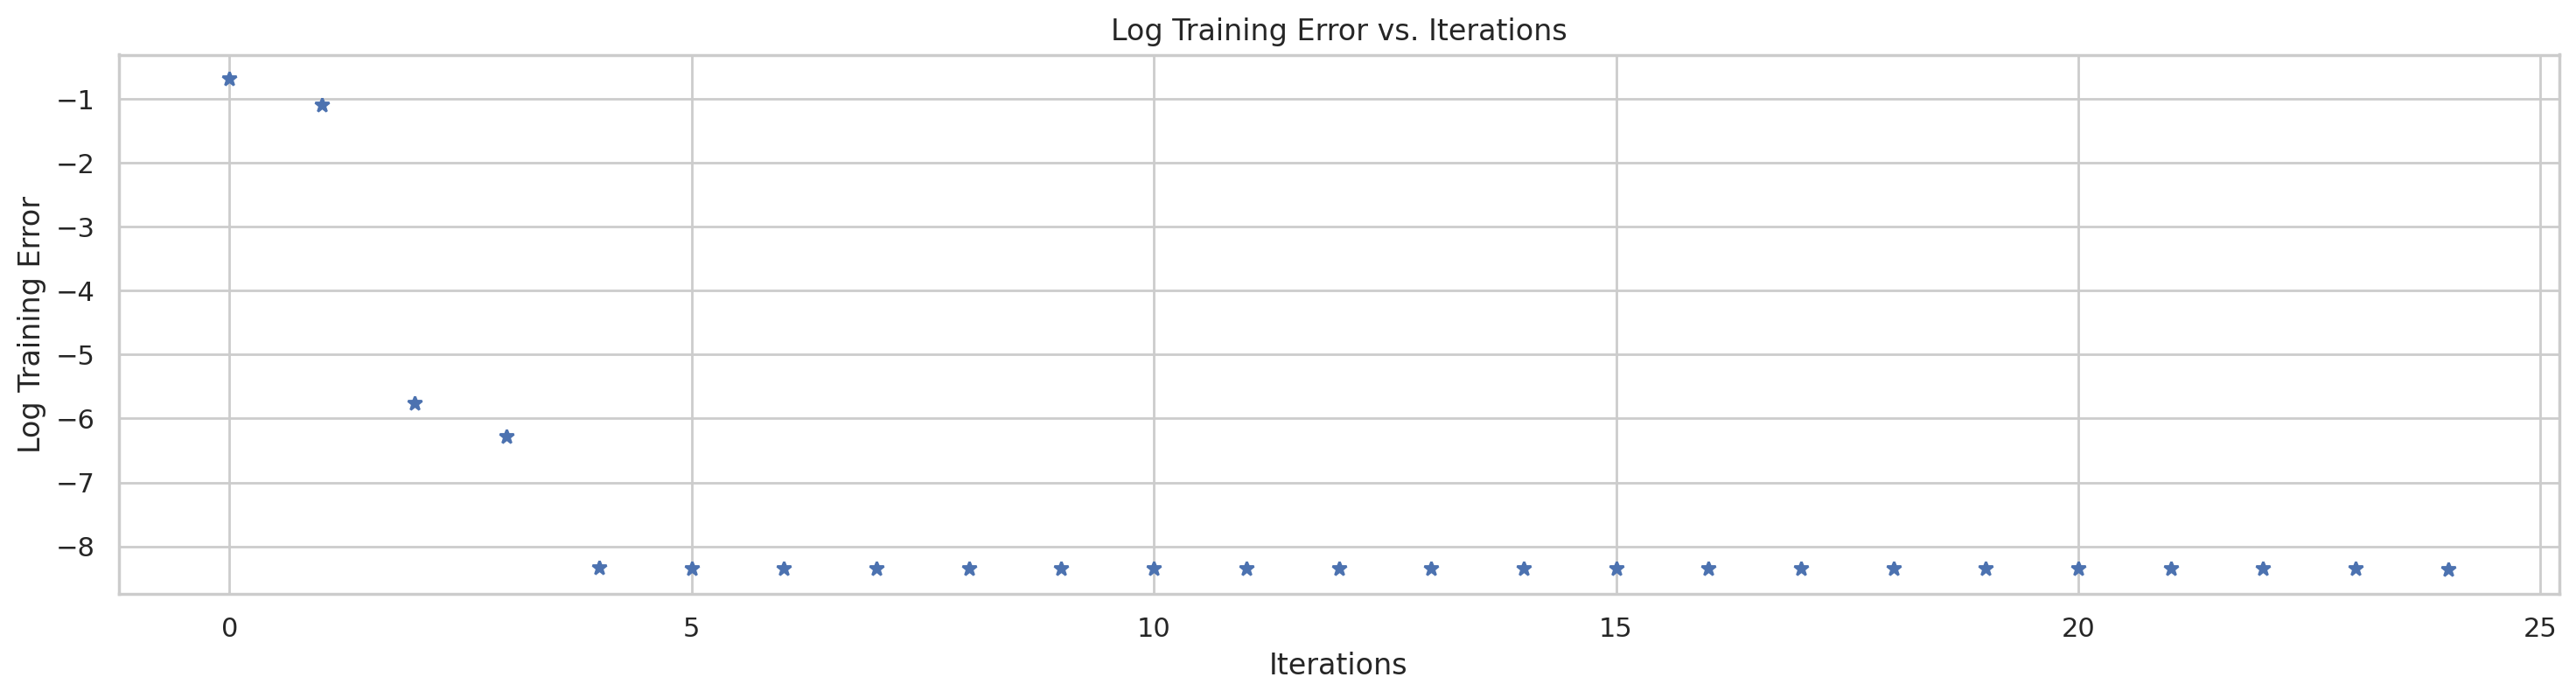

In [42]:
#Inspect and Model the metrics and Coefficient and Visualize the log of the training error as a function of iteration. 
#The scatter plot visualizes the logarithm of the training error for all 10 iterations.

iterations = list(range(0,linearModel.summary.totalIterations + 1))
lossHistory = np.log(linearModel.summary.objectiveHistory)
plt.plot(iterations,lossHistory,'*')
plt.title('Log Training Error vs. Iterations')
plt.ylabel('Log Training Error')
plt.xlabel('Iterations')
# Intercept for the model
print("MAE: {0}".format(linearModel.summary.meanAbsoluteError))

/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/home/ubuntu/.local/lib/python3.10/site-packages/pyspark/sql/context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(
/tmp/ipykernel_57573/849240240.py:8: UserWarning:                               

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
/tmp/ipykernel_57573/849240240.py:9: UserWarning: 

`distplot` is a deprecated function and will be removed in seabo

<AxesSubplot: ylabel='Density'>

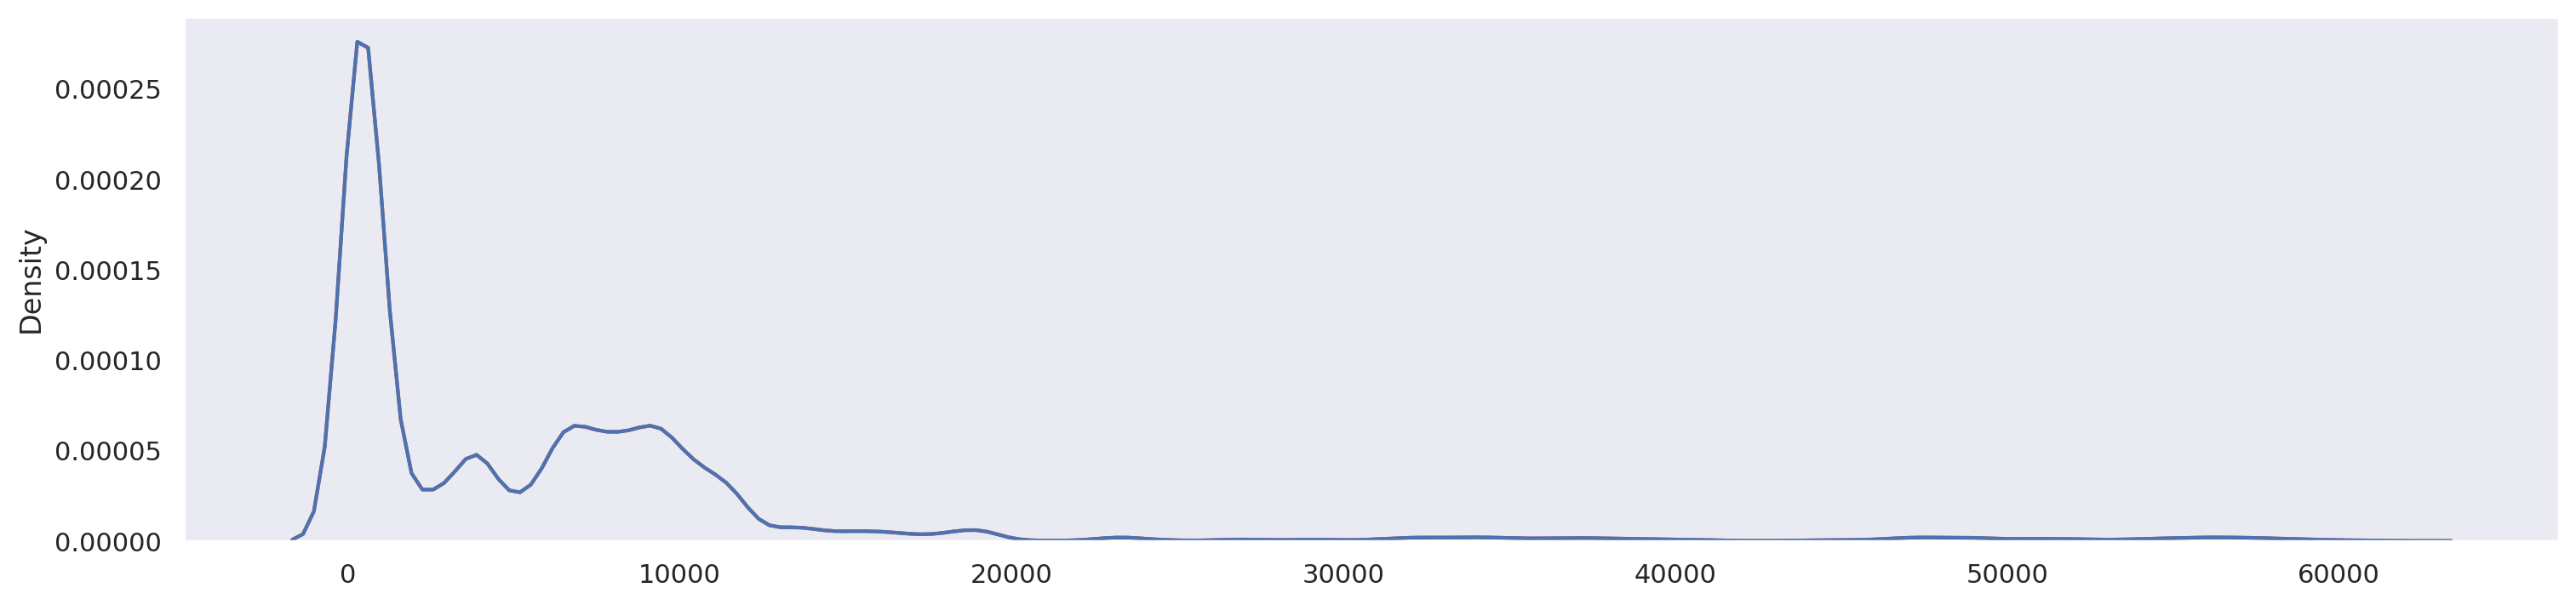

In [43]:
# Use the method "predict" to predict an output on the polynomial features,
# then use the function "DistributionPlot" to display the distribution of the Predicted_Price vs the Weighted_Price from the test data

pred_results=linearModel.evaluate(test_data)
Y = pred_results.predictions.select('Weighted_Price').toPandas()
_Y = pred_results.predictions.select("Predicted_price").toPandas()
sns.set_style("dark")
ax1= sns.distplot(Y, hist=False, color="r", label="Actual Values")
sns.distplot(_Y, hist=False, color="b", label="Fitted Values" , ax=ax1)

<Figure size 1200x700 with 0 Axes>

Text(0.5, 1.0, 'BitCoin Weighted Prediction')

Text(0.5, 0, 'Weighted_Price')

Text(0, 0.5, 'Predicted_price')

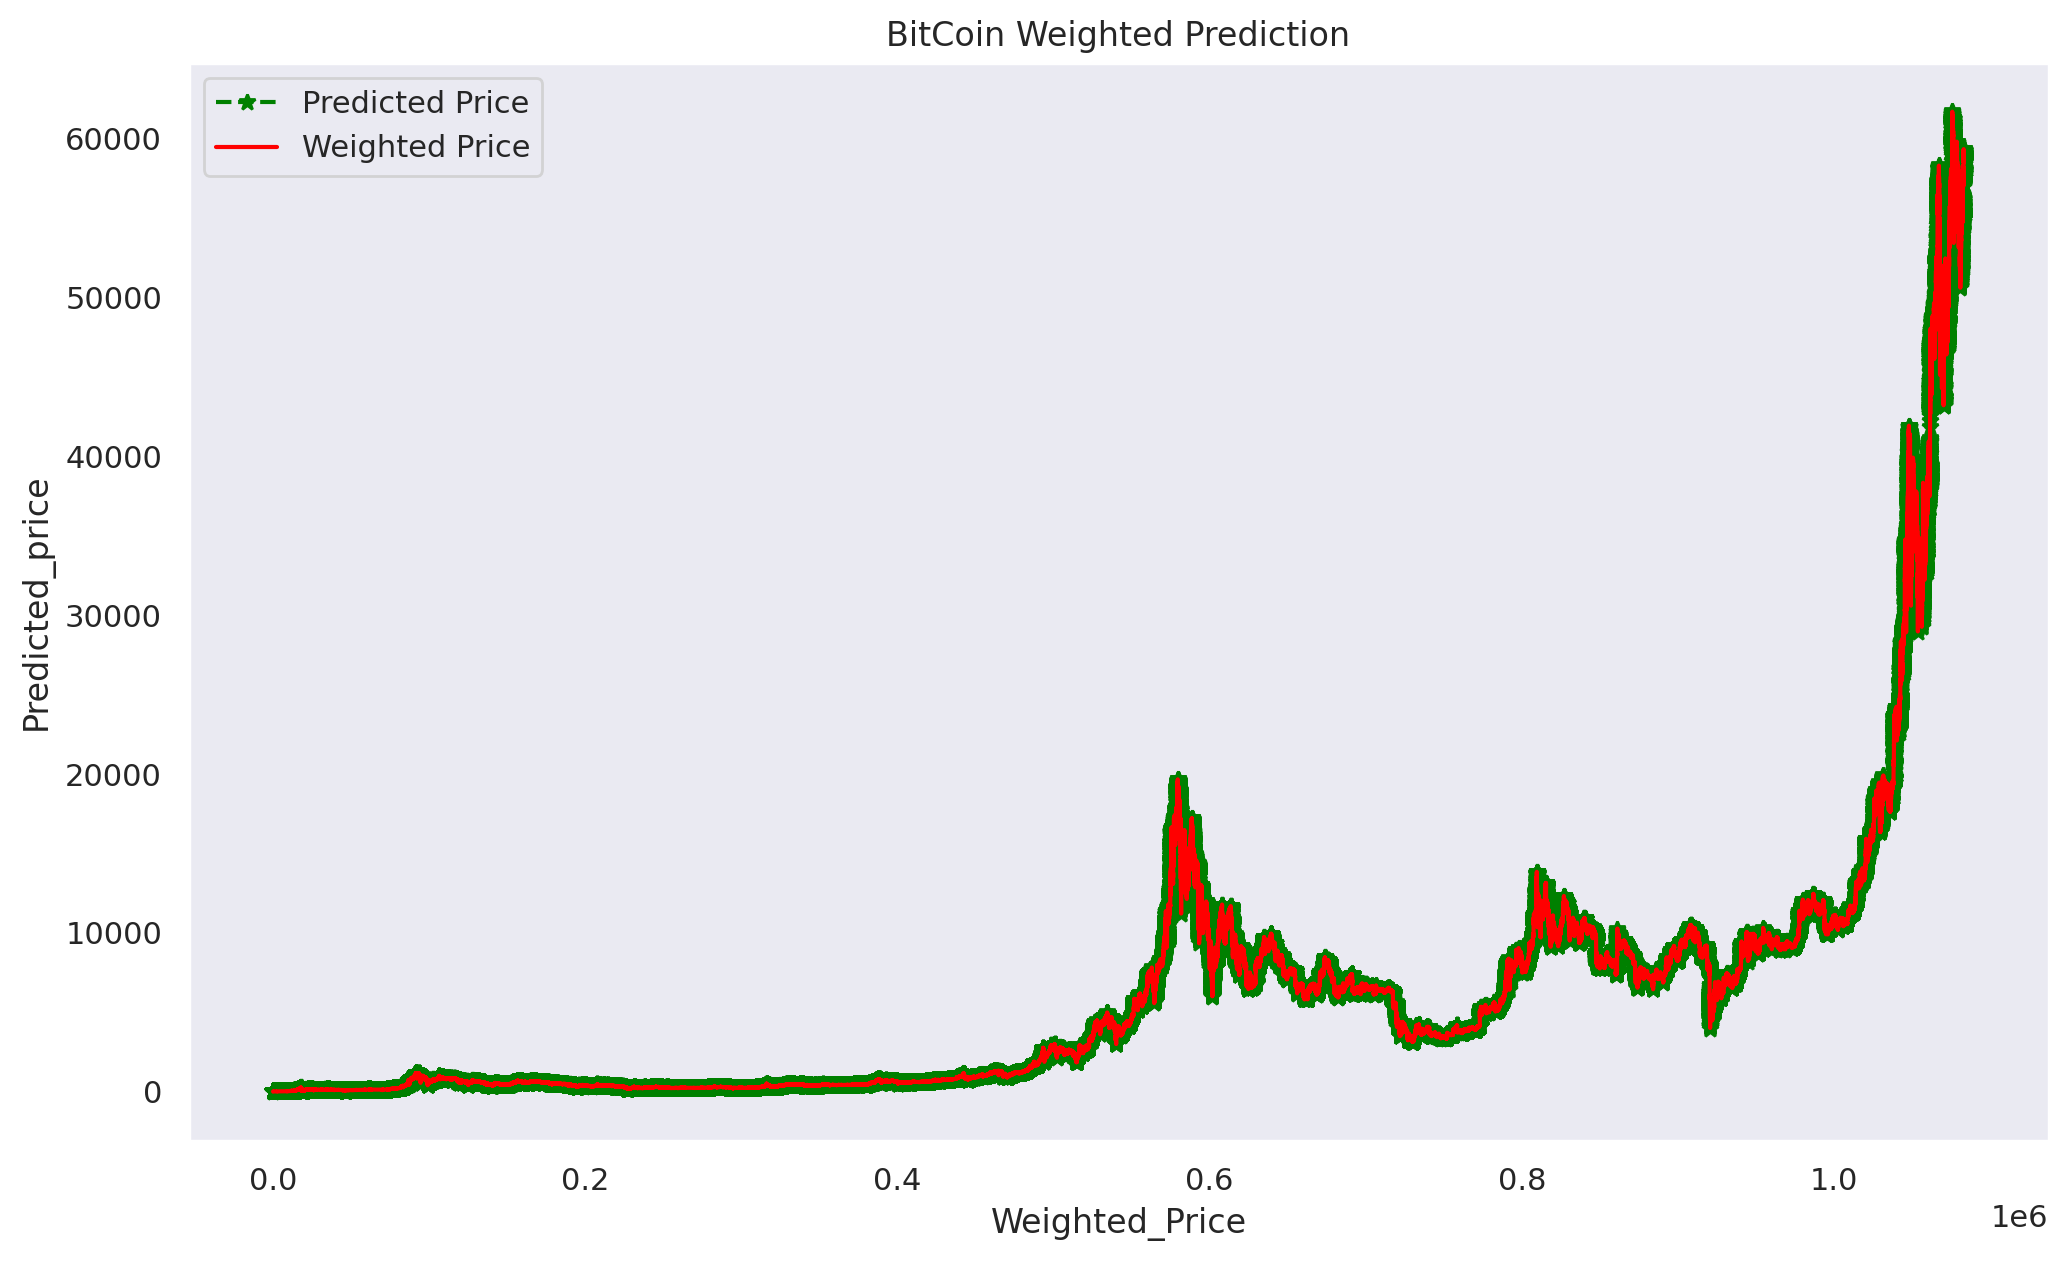

In [44]:
#Plotting Weighted_price vs Predicted_price using Matplotlib
plt.figure(figsize=(12,7))
plt.plot(Y, color='green', marker='*', linestyle='dashed', 
         label='Predicted Price')
plt.plot(_Y, color='red', label='Weighted Price')
plt.title('BitCoin Weighted Prediction')
plt.xlabel('Weighted_Price')
plt.ylabel('Predicted_price')
plt.legend()

In [45]:
spark_session.stop()